In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import yaml
from collections import defaultdict
import pprint

### Import column dictionary from yaml

The yaml file has information regarding the data in the following form:

  ```
  dictionary:
      school.name:
        source: INSTNM
        type: autocomplete
        description: Institution name
        index: fulltext 
  ```
The type indicates the data type and should be indicated when reading in the college scorecard csv.  
Null values are written as ```NULL``` or ```PrivacySupressed```.   
The dictionary is nested. For the example above, the ```school.name``` key returns four more keys ```source, type, description, index```. Each of those keys returns a value. The colum name is under the nested key ```source```. It needs to be flipped so that the value of ```source``` is the main key.

In [2]:
yaml_file = open("/Users/meng/Desktop/DS4A/CollegeScorecard_Raw_Data_08032021/data.yaml", 'r')
yaml_content = yaml.load(yaml_file)

## Need to flip the dictionary so that the the keys match the column names
flippeddict = defaultdict(dict)
try:
    for key, val in yaml_content["dictionary"].items():
        newkey = val['source']
        for subkey, subval in val.items():
            flippeddict[newkey][subkey] = subval
except KeyError:
    pass

# pprint.pprint(dict(flippeddict))

/Users/meng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


*Work in progress, defining columns of interest*

In [3]:
cols_of_interest = ['INSTNM',  
                    'COSTT4_A', 'COSTT4_P', 'DEBT_MDN','MN_EARN_WNE_P6','MN_EARN_WNE_P8','MN_EARN_WNE_P10','TUITFTE', 'AVGFACSAL', 'ADM_RATE_ALL', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'ACTCM25', 
                    'ACTCM75', 'UGDS', 'UG25ABV', 'PCTFLOAN', 'CDR3' ]
cols_numeric = ['COSTT4_A', 'COSTT4_P', 'DEBT_MDN','MN_EARN_WNE_P6','MN_EARN_WNE_P8','MN_EARN_WNE_P10','TUITFTE', 'AVGFACSAL', 'ADM_RATE_ALL', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'ACTCM25', 
                    'ACTCM75', 'UGDS', 'UG25ABV', 'PCTFLOAN', 'CDR3' ]

# Import data

First a function is defined to read and merge csv files. Next the fucntion is run from the year 1996-2020.   
<div class="alert-danger">
To do: use yaml file to pipe in dtypes for each column
</div>

In [4]:
# Define a function read and merge all years
def read_cs_data(year,datadir):
    """read a CollegeScorecard dataframe"""
    nextyr = str(int(year) + 1)[-2:]
    filename = datadir + '/MERGED{}_{}_PP.csv'.format(year,nextyr)
    
    # Specify dtype because guessing dtypes is very memory intensive
    # Specify that "PrivacySuppressed" are NaN values
    # Eventually can use usecols to specify which columns of interest to import
    col = pd.read_csv(filename, dtype='unicode',na_values='PrivacySuppressed') 
    col['Year'] = pd.Period(str(int(year) + 1),freq='Y')
    return col

In [5]:
datadir = "/Users/meng/Desktop/DS4A/CollegeScorecard_Raw_Data_08032021"
df = pd.concat((read_cs_data(str(y),datadir) for y in range(2000,2015)))
df = df.set_index(['UNITID','Year'])
# df_subset = df[cols_of_interest]

In [6]:
df.head()

,,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,SCH_DEG,...,FEDSCHCD,BOOKSUPPLY,ROOMBOARD_ON,OTHEREXPENSE_ON,ROOMBOARD_OFF,OTHEREXPENSE_OFF,OTHEREXPENSE_FAM,ENDOWBEGIN,ENDOWEND,DOLPROVIDER
UNITID,Year,,,,,,,,,,,,,,,,,,,,,
100636,2001,01230800,012308,Community College of the Air Force,Montgomery,AL,36114-3011,NaN,NaN,NaN,NaN,...,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100654,2001,00100200,001002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,3,...,NaN,800,4500,1000,6000,1500,600,NaN,NaN,NaN
100663,2001,00105200,001052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,3,...,NaN,900,6471,2438,7875,3375,3375,NaN,NaN,NaN
100690,2001,02503400,025034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100706,2001,00105500,001055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,3,...,NaN,720,4300,2100,5345,2550,2250,NaN,NaN,NaN


### Save merged csv to disk

Next time, this merged csv can be read directly to skip the time-consuming step of reading each year separately.

In [7]:
df.to_csv('ALLMERGED.csv') # Export to csv

In [8]:
## Use this to read in merged csv directly
df = pd.read_csv('ALLMERGED.csv', dtype='unicode',na_values='PrivacySuppressed') 

# Data cleaning

To begin, columns with more than 60% ```NaN``` values are omitted. This can percentage can be changed in the code. Three variables related to earnings post-graduation are added back in, ```MN_EARN_WNE_P6,MN_EARN_WNE_P8,MN_EARN_WNE_P10```. There are likely more that can be added back easily.

### Dropping columns with too many ```NaN```

In [9]:
# Function to get a table of missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [10]:
mis_val = missing_values_table(df)
mis_val.head()

Your selected dataframe has 2393 columns.
There are 2380 columns that have missing values.


,Missing Values,% of Total Values
ACCREDAGENCY,107257,100.0
OMENRUP_PARTTIME_POOLED_SUPP,107257,100.0
OMENRAP_FIRSTTIME_POOLED_SUPP,107257,100.0
OMAWDP8_FIRSTTIME_POOLED_SUPP,107257,100.0
OMENRUP_FIRSTTIME_POOLED_SUPP,107257,100.0


In [11]:
# Drop columms with more than 60% NaN
df_dropna = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)

# Add back in certain columns
cols_to_add = ['MN_EARN_WNE_P6','MN_EARN_WNE_P8','MN_EARN_WNE_P10']
for col in cols_to_add:
    df_dropna[col] = df[col]

/Users/meng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
print("Shape before:", df.shape, " Shape after:", df_dropna.shape)

Shape before: (107257, 2393)  Shape after: (107257, 395)


Drop columns ending in ```ASSOC, CERT1, CERT2, CERT4, BACHL```. These correspond to whether an institution offers bachelors, associate degree, and diploma for 1, 2, and 4 years in the program.

In [13]:
df_drop2 = df_dropna.loc[:, ~df_dropna.columns.str.endswith('ASSOC')]
df_drop2 = df_drop2.loc[:, ~df_drop2.columns.str.endswith('CERT2')]
df_drop2 = df_drop2.loc[:, ~df_drop2.columns.str.endswith('CERT1')]
df_drop2 = df_drop2.loc[:, ~df_drop2.columns.str.endswith('CERT4')]
df_drop2 = df_drop2.loc[:, ~df_drop2.columns.str.startswith('BACHL')] #PCIP

In [14]:
print("Shape before:", df_dropna.shape, " Shape after:", df_drop2.shape)

Shape before: (107257, 395)  Shape after: (107257, 243)


### Sum fields of studies into broader categories

Here the ```PCIP``` variables are used, which represent percentage of students in a specific field 

In [41]:
df_drop3 = df_drop2.copy()

### Clumping fields of studies into broad categories

In [42]:
natresources = ['PCIP01','PCIP03','PCIP31']
social = ['PCIP05','PCIP09','PCIP13','PCIP19','PCIP22','PCIP30','PCIP44','PCIP45','PCIP51']
stem = ['PCIP04','PCIP11','PCIP14','PCIP15','PCIP26','PCIP27','PCIP29','PCIP40','PCIP41','PCIP42','PCIP47']
humanities = ['PCIP16','PCIP23','PCIP24','PCIP38','PCIP39','PCIP50','PCIP54']
techtrade = ['PCIP10','PCIP12','PCIP25','PCIP43','PCIP46','PCIP48','PCIP49']
business = ['PCIP52']

def sumcols(df, columns, summedcolname):
    for col in columns:
        df[col] = df[col].astype(float)

    df[summedcolname] = df[columns].sum(axis=1)

sumcols(df_drop3,natresources,"Field_NR")
sumcols(df_drop3,social,"Field_social")
sumcols(df_drop3,stem,"Field_STEM")
sumcols(df_drop3,humanities,"Field_AH")
sumcols(df_drop3,techtrade,"Field_techtrade")
sumcols(df_drop3,business,"Field_bus")

In [43]:
df_drop3.head()
df_drop3.sort_values(by='Field_STEM', ascending=False)["Field_STEM"]

26186     1.0001
1939      1.0001
61988     1.0001
39702     1.0001
26442     1.0001
           ...  
67154     0.0000
67155     0.0000
25477     0.0000
67157     0.0000
107256    0.0000
Name: Field_STEM, Length: 107257, dtype: float64

In [44]:
df_drop3["TUITFTE"] = df_drop3["TUITFTE"].astype(float)
df_drop3.loc[~(df_drop3['TUITFTE'] > 1), 'TUITFTE']=np.nan

### Exploratory data analysis: some plots

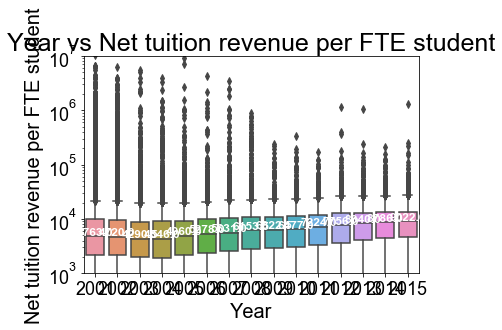

In [19]:
# Boxplot of TUITFTE over the years
ax = sns.boxplot(x="Year", y="TUITFTE", data=df_drop3)
sns.set(rc={'figure.figsize':(19.7,6.27)})
ax.set(yscale="log")
ax.set(ylim=(1000,10000000))
ax.set_title("Year vs Net tuition revenue per FTE student",fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Net tuition revenue per FTE student', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
medians = df_drop3.groupby(['Year'])['TUITFTE'].median()
vertical_offset = df_drop3['TUITFTE'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
ax.get_figure().savefig('Year_vs_TUITFTE.png')

In [20]:
df_drop3.sort_values(by='TUITFTE', ascending=False)["TUITFTE"]

20284     26670163.0
596       11932462.0
1476      10414750.0
31713      8969462.0
33327      7014195.0
             ...    
107252           NaN
107253           NaN
107254           NaN
107255           NaN
107256           NaN
Name: TUITFTE, Length: 107257, dtype: float64

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

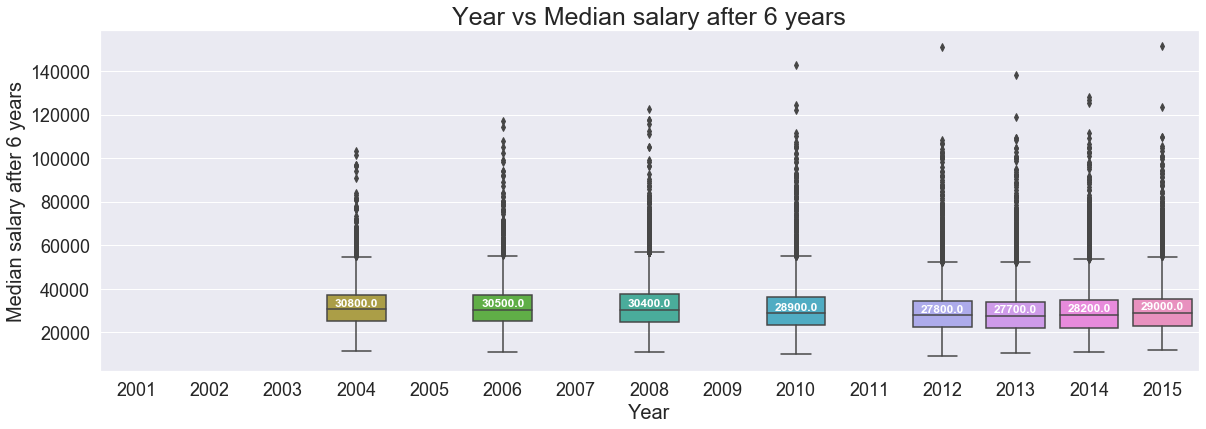

In [21]:
# Boxplot of MN_EARN_WNE_P6 over the years
df_drop3["MN_EARN_WNE_P6"] = df_drop3["MN_EARN_WNE_P6"].astype(float)
ax = sns.boxplot(x="Year", y="MN_EARN_WNE_P6", data=df_drop3)
sns.set(rc={'figure.figsize':(19.7,6.27)})
# ax.set(yscale="log")
# ax.set(ylim=(1000,10000000))
ax.set_title("Year vs Median salary after 6 years",fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Median salary after 6 years', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
medians = df_drop3.groupby(['Year'])['MN_EARN_WNE_P6'].median()
vertical_offset = df_drop3['MN_EARN_WNE_P6'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
ax.get_figure().savefig('Year_vs_MN_EARN_WNE_P6.png')


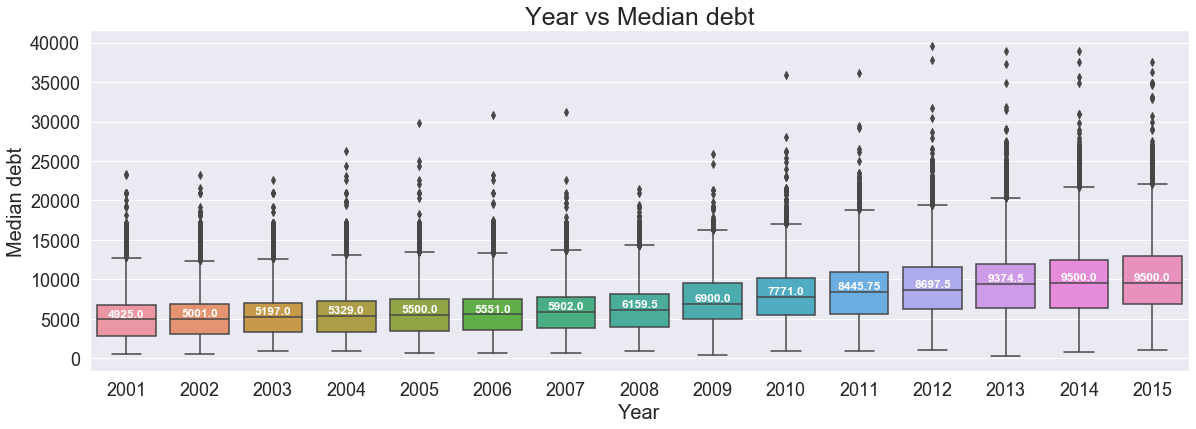

In [22]:
# Boxplot of DEBT_MDN over the years
df_drop3["DEBT_MDN"] = df_drop3["DEBT_MDN"].astype(float)
ax = sns.boxplot(x="Year", y="DEBT_MDN", data=df_drop3)
sns.set(rc={'figure.figsize':(19.7,6.27)})
# ax.set(yscale="log")
# ax.set(ylim=(1000,10000000))
ax.set_title("Year vs Median debt",fontsize=25)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Median debt', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
medians = df_drop3.groupby(['Year'])['DEBT_MDN'].median()
vertical_offset = df_drop3['DEBT_MDN'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
ax.get_figure().savefig('Year_vs_DEBT_MDN.png')


In [23]:
df_drop3["MALE_DEBT_MDN"] = df_drop3["MALE_DEBT_MDN"].astype(float)
df_drop3cut = df_drop3[(df_drop3['TUITFTE'].between(0, 25000)) & (df_drop3["MALE_DEBT_MDN"].between(0, 20000))]
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.histplot(df_drop3cut, y="TUITFTE", x="MALE_DEBT_MDN", bins=50, pthresh=.1, cmap="mako")
# plt.title("Median debt  vs Net tuition revenue")
ax.set_title("Median debt (male) vs Net tuition revenue",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Net tuition revenue', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

AttributeError: module 'seaborn' has no attribute 'histplot'

In [24]:
df_drop3["FEMALE_DEBT_MDN"] = df_drop3["FEMALE_DEBT_MDN"].astype(float)
df_drop3cut = df_drop3[(df_drop3['TUITFTE'].between(0, 25000)) & (df_drop3["FEMALE_DEBT_MDN"].between(0, 20000))]
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.histplot(df_drop3cut, y="TUITFTE", x="FEMALE_DEBT_MDN", bins=50, pthresh=.1, cmap="mako")
# plt.title("Median debt vs Net tuition revenue")
ax.set_title("Median debt (female) vs Net tuition revenue",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Net tuition revenue', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

AttributeError: module 'seaborn' has no attribute 'histplot'

In [25]:
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.histplot(df_drop3cut, x="FEMALE_DEBT_MDN", bins=20)
sns.set(rc={'figure.figsize':(10,10)})
# plt.title("Median debt vs Net tuition revenue")
ax.set_title("Median debt (female)",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

AttributeError: module 'seaborn' has no attribute 'histplot'

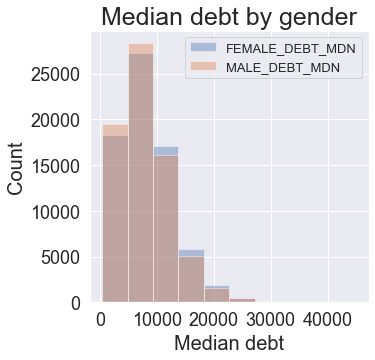

In [26]:
## Median debt by gender
ax = df_drop3[["FEMALE_DEBT_MDN", "MALE_DEBT_MDN"]].plot.hist(alpha=0.4)
ax.set_title("Median debt by gender",fontsize=25)
sns.set(rc={'figure.figsize':(10,10)})
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc=1, prop={'size': 13})

ax.get_figure().savefig('debt_by_gender.png')

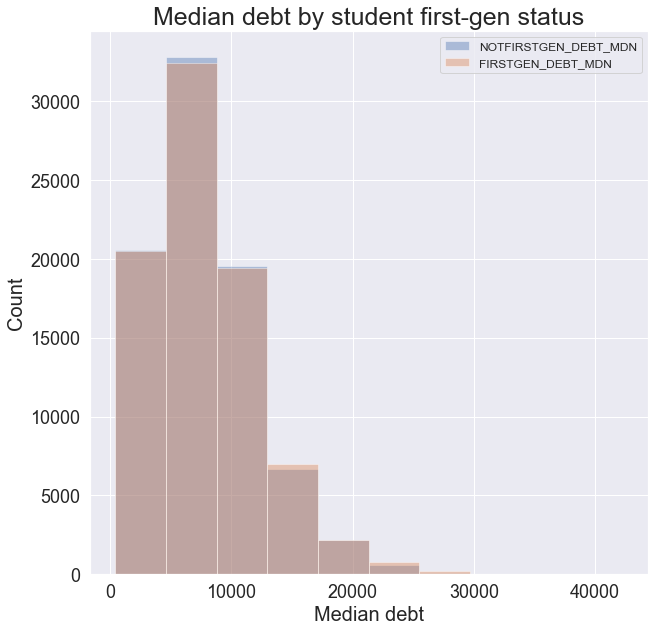

In [27]:
## Median debt by whether or not the student is first-generation
df_drop3["NOTFIRSTGEN_DEBT_MDN"] = df_drop3["NOTFIRSTGEN_DEBT_MDN"].astype(float)
df_drop3["FIRSTGEN_DEBT_MDN"] = df_drop3["FIRSTGEN_DEBT_MDN"].astype(float)
ax = df_drop3[["NOTFIRSTGEN_DEBT_MDN", "FIRSTGEN_DEBT_MDN"]].plot.hist(alpha=0.4)
sns.set(rc={'figure.figsize':(10,10)})
ax.set_title("Median debt by student first-gen status",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc=1, prop={'size': 12})

ax.get_figure().savefig('debt_by_1stgen.png')

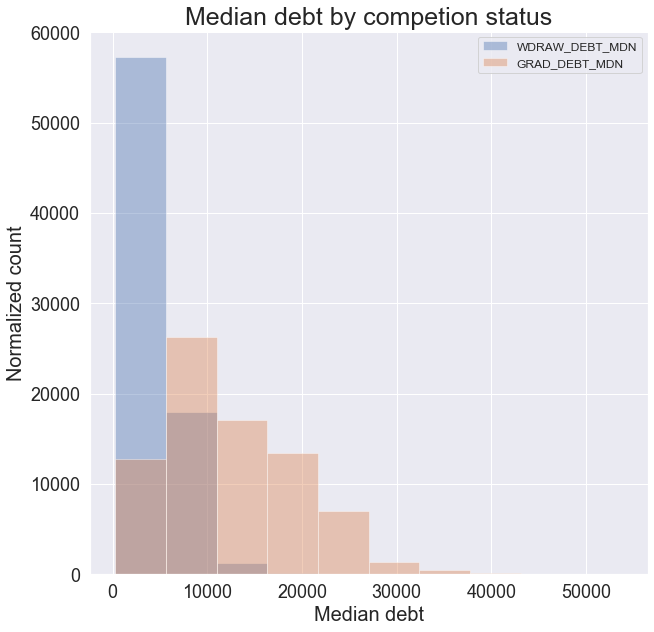

In [28]:
## Median debt by whether or not the student is first-generation
df_drop3["WDRAW_DEBT_MDN"] = df_drop3["WDRAW_DEBT_MDN"].astype(float)
df_drop3["GRAD_DEBT_MDN"] = df_drop3["GRAD_DEBT_MDN"].astype(float)
ax = df_drop3[["WDRAW_DEBT_MDN", "GRAD_DEBT_MDN"]].plot.hist(alpha=0.4)
sns.set(rc={'figure.figsize':(10,10)})
ax.set_title("Median debt by competion status",fontsize=25)
ax.set_xlabel('Median debt', fontsize=20)
ax.set_ylabel('Normalized count', fontsize=20)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.legend(loc=1, prop={'size': 12})

ax.get_figure().savefig('debt_by_completion.png')

Save list of cleaned columns to txt file

In [29]:
# Save list of columns to txt file
myfile = open('CollegeScorecardCleanedColumns.csv', 'w')
for col in df_drop2.columns:
    try:
#         print(col,":", flippeddict[col]["description"])
        var1=col+","+" "+flippeddict[col]["description"]
        myfile.write("%s\n" % var1)
    except KeyError:
        pass
myfile.close()

### Use dictionary from yaml to change column dtypes

Must do this after defining columns of interest. It is too time consuming to do it for the whole dataset.

In [30]:
# Function to set dtypes on columns of interest in a dataframe using the yaml flipped dictionary from
def setdtypes(cols_of_interest, df, flippeddict):
    for col in cols_of_interest:
        print("Doing ",cols_of_interest)
        try:
            if flippeddict[col]["type"] == "integer":
                df[col] = df[col].astype("int")
                print("dtype changed to int.")
            elif flippeddict[col]["type"] == "float":
                df[col] = df[col].astype("float")
                print("dtype changed to float.")
            else:
                pass
        except KeyError:
            print("KeyError, skipping")
            pass
        except ValueError:
            print("ValueError, skipping")
            pass
        
#     print(flippeddict[col])

In [ ]:
# df["ACTCM25"] = df['PCTFLOAN'].astype('float')
# df["ADM_RATE_ALL"].dtypes

# Determining feature importance

Going to try to use some models to determine which features are important. Work in progress.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer

model=c(random_state=1)
 
features=df
 
model.fit(features,df_dropna['MN_EARN_WNE_P6'])
 
feature_importance=pd.DataFrame({'feature':list(features.columns),'feature_importance':[abs(i) for i in model.coef_[0]]})
feature_importance.sort_values('feature_importance',ascending=False)
 

ValueError: could not convert string to float: '001057A1'

# Fearure Selection

LASSO (L1 Regularization)

In [31]:
from sklearn.preprocessing import StandardScaler
import math
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import copy

Split the data into training (before 2012) and test (after 2012) datasets (Assuming regressing MN_EARN_WNE_P6 (can use other variables here) on other variables)

In [46]:
#df_drop3["Year"] =  pd.to_datetime(df_drop3["Year"]).dt.year
data = copy.deepcopy(df_drop3.drop(columns = ['UNITID', 'OPEID','OPEID6','INSTNM', 'CITY', 'STABBR','ZIP','SEPAR_DT_MDN']))
data = data.apply(pd.to_numeric)

#Drop rows where MN_EARN_WNE_P6 is NaN since MN_EARN_WNE_P6 is our dependent variable here and cannot be NaN
#data_MN_EARN_WNE_P6 = data.dropna(subset = ["MN_EARN_WNE_P6"], inplace=True)
data_MN_EARN_WNE_P6 = data[data['MN_EARN_WNE_P6'].notna()]


In [45]:
df_drop3

,UNITID,Year,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,...,UG12MN,MN_EARN_WNE_P6,MN_EARN_WNE_P8,MN_EARN_WNE_P10,Field_NR,Field_social,Field_STEM,Field_AH,Field_techtrade,Field_bus
0,100636,2001,01230800,012308,Community College of the Air Force,Montgomery,AL,36114-3011,NaN,1,...,412000,NaN,NaN,NaN,0.0077,0.1806,0.4144,0.0067,0.1683,0.2225
1,100654,2001,00100200,001002,Alabama A & M University,Normal,AL,35762,3,1,...,4187,NaN,NaN,NaN,0.0807,0.3725,0.3285,0.0147,0.0239,0.1798
2,100663,2001,00105200,001052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,3,1,...,13458,NaN,NaN,NaN,0.0000,0.4213,0.2458,0.0946,0.0467,0.1914
3,100690,2001,02503400,025034,Amridge University,Montgomery,AL,36117-3553,3,1,...,168,NaN,NaN,NaN,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
4,100706,2001,00105500,001055,University of Alabama in Huntsville,Huntsville,AL,35899,3,1,...,7452,NaN,NaN,NaN,0.0000,0.2214,0.4294,0.1100,0.0000,0.2392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107252,48065701,2015,00869423,008694,Rasmussen College - Overland Park,Overland Park,KS,662102786,2,0,...,NaN,29900,32700,34300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
107253,48154401,2015,04220901,042209,National Personal Training Institute of Cleveland,Highland Heights,OH,44143,1,0,...,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
107254,48387801,2015,04223701,042237,Bay Area Medical Academy - San Jose Satellite ...,San Jose,CA,95113,1,0,...,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
107255,48400201,2015,04228101,042281,High Desert Medical College - Bakerfield,Bakersfield,CA,93301,1,0,...,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [48]:
data_train = data_MN_EARN_WNE_P6[data_MN_EARN_WNE_P6['Year']<=2012]
data_test = data_MN_EARN_WNE_P6[data_MN_EARN_WNE_P6['Year']>2012]

X_train = data_train.drop(columns=['Year','MN_EARN_WNE_P6']).fillna(0)
y_train = data_train['MN_EARN_WNE_P6']
X_test = data_test.drop(columns=['Year','MN_EARN_WNE_P6']).fillna(0)
y_test = data_test['MN_EARN_WNE_P6']

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [49]:
# LASSO feature selection
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)
sel_.get_support()

selected_feat = X_train.columns[(sel_.get_support())]
selected_feat # This is the features selected by LASSO

/Users/meng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/meng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Index(['SCH_DEG', 'MAIN', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL',
       'ST_FIPS', 'REGION', 'PCIP01', 'PCIP03',
       ...
       'OPEFLAG', 'UG12MN', 'MN_EARN_WNE_P8', 'MN_EARN_WNE_P10', 'Field_NR',
       'Field_social', 'Field_STEM', 'Field_AH', 'Field_techtrade',
       'Field_bus'],
      dtype='object', length=227)

In [50]:
#Keep Only the Selected Features by LASSO and Run Logistic Regression
X_train_selected = sel_.transform(X_train.fillna(0))
X_test_selected = sel_.transform(X_test.fillna(0))
model = LogisticRegression(penalty='none', solver = 'saga', fit_intercept=False).fit(X_train_selected, y_train)
model.score(X_test_selected, y_test)

/Users/meng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/meng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.0032179784764718297

Ridge (L2 Regularization)

In [51]:
sel_2 = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
sel_2.fit(scaler.transform(X_train.fillna(0)), y_train)
sel_2.get_support()
selected_feat_2 = X_train.columns[(sel_2.get_support())]
selected_feat_2

/Users/meng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/meng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Index(['SCH_DEG', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL', 'CIP09BACHL',
       'CIP11BACHL', 'CIP13BACHL', 'CIP16BACHL', 'CIP23BACHL',
       ...
       'DEBT_MDN_SUPP', 'GRAD_DEBT_MDN_SUPP', 'ICLEVEL', 'UGDS_MEN',
       'UGDS_WOMEN', 'CDR2_DENOM', 'OPENADMP', 'UG12MN', 'MN_EARN_WNE_P8',
       'MN_EARN_WNE_P10'],
      dtype='object', length=103)

In [52]:
#Keep Only the Selected Features by Ridge Rgularization and Run Logistic Regression
X_train_selected_2 = sel_2.transform(X_train.fillna(0))
X_test_selected_2 = sel_2.transform(X_test.fillna(0))
model_ = LogisticRegression(penalty='none', solver = 'saga', fit_intercept=False).fit(X_train_selected_2, y_train)
model_.score(X_test_selected_2, y_test)

/Users/meng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/meng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.005380882042625027

### Plotting stuff

In [ ]:
df_subset = df[cols_of_interest]
for col in cols_numeric:
    df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce')
df_subset.info()

In [ ]:
sns.histplot(df_subset, y="TUITFTE", x="DEBT_MDN", bins=50, pthresh=.1, cmap="mako")
plt.title("Cost of tuition vs Median earnings after 6 years")